# Elliptical Equation Inversion

In [1]:
import autoroot
import jax
import jax.numpy as jnp
from jax.config import config
import numpy as np
import numba as nb
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read input SSH

In [2]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:   (time: 24, lat: 200, lon: 200)
Coordinates:
  * lon       (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat       (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time      (time) datetime64[ns] 2012-10-01T00:30:00 ... 2012-10-01T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 ...
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [3]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.sossheig[0].values


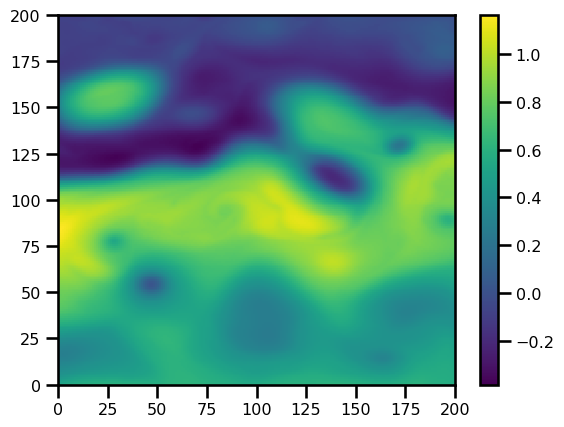

In [4]:
plt.figure()
plt.pcolormesh(ssh)
plt.colorbar()

## Forward elliptical equation: get PV from SSH on cartesian grid

$$
\begin{aligned}
q &= \frac{g}{f_0} \nabla^ 2 \eta - \frac{g f_0}{c_1^2} \eta \\
q &= \left(\nabla^ 2 - \frac{f_0^2}{c_1^2} \right) \frac{g}{f_0}  \eta
\end{aligned}
$$

We are solving the following equation:

$$
\begin{aligned}
\mathcal{N}[q;\theta](\vec{\mathbf{x}}) &= \frac{g}{f_0}\nabla^2\eta-\frac{gf_0}{c_1^2}\eta,
&& && \vec{\mathbf{x}}\in\Omega \\
\mathcal{BC}[q;\theta](\vec{\mathbf{x}}) &= 
-\frac{gf_0}{c_1^2}\eta, 
&& && \vec{\mathbf{x}}\in\partial\Omega
\end{aligned}
$$

where the parameters are $\theta=\{g,f_0,c_1\}$. 

**Step I**: Compute the potential vorticity, $q$, with the boundaries.

$$
\begin{aligned}
q &= \frac{g}{f_0}\nabla^2\eta - \frac{gf_0}{c_1^2}\eta, 
&& && \vec{\mathbf{x}}\in\Omega \\
q &= -\frac{gf_0}{c_1^2}\eta, 
&& && \vec{\mathbf{x}}\in\partial\Omega
\end{aligned}
$$

**Step II**: Compute the sea surface height, $\eta$, without the interior points, $\eta_0$.

$$
\begin{aligned}
\eta_0 &:= \mathcal{N}[\eta](\vec{\mathbf{x}}) = 0,
&& && \vec{\mathbf{x}}\in\Omega \\
\eta_0 &:= \mathcal{N}[\eta_0](\vec{\mathbf{x}})=\eta, 
&& && \vec{\mathbf{x}}\in\partial\Omega
\end{aligned}
$$

**Step III**: We compute the potential vorticity without the interior points, $q_0$.

$$
\begin{aligned}
q_0 &= \frac{g}{f_0}\nabla^2\eta_0 - \frac{gf_0}{c_1^2}\eta_0, && && \vec{\mathbf{x}}\in\Omega \\
q_0 &= -\frac{gf_0}{c_1^2}\eta_0, && && \vec{\mathbf{x}}\in\partial\Omega
\end{aligned}
$$

**Step IV**: We compute the boundary effects of $q_0$ from the potential vorticity $q$

$$
\begin{aligned}
q_\xi &= q - q_0 && && \vec{\mathbf{x}}\in\Omega 
\end{aligned}
$$

**Step V**: We compute the elliptical operator in Fourer space with the discrete sign transform

$$
\begin{aligned}
\hat{\nabla}^2 &= \mathcal{F}(\nabla^2) \\
\hat{\nabla}^2_H &= \frac{g}{f_0}\hat{\nabla}^2 - \frac{gf_0}{c_1^2} \\
\end{aligned}
$$

**Step VI**: Compute the potential vorticity in the Fourier domain with the discrete sine transformation.

$$
\hat{q}_\xi = \mathcal{F}(q_\xi)
$$

**Step VII**: Compute the sea surface height in the Fourier domain.

$$
\hat{\eta}_\xi = \frac{1}{\hat{\nabla}^2}\hat{q}_\xi
$$

**Step VIII**: Compute the sea surface height in the real domain with the inverse discrete sine transformation.

$$
\eta_\xi = \mathcal{F}^{-1}(\hat{\eta}_\xi)
$$


**Step IX**: Add the boundary value effect to the sea surface height.

$$
\begin{aligned}
\eta &= \eta_\xi, && && \vec{\mathbf{x}}\in\Omega \\
\eta &= \eta_0, && && \vec{\mathbf{x}}\in\partial\Omega
\end{aligned}
$$

In [5]:
dx,dy = 4000, 4000 # meters
x = np.arange(0,dx*lon.size,dx)
y = np.arange(0,dy*lat.size,dy)

nx = lon.size
ny = lat.size


# Constants 
g = 9.91 # Gravity
f0 = 1e-5 # Coriolis frequency
c1 = 2.7 # First baroclinic phase speed

### SSH

In [6]:
def min_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.min(), arrays))
    return np.min(np.stack([*arrays],axis=0))

def max_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.max(), arrays))
    return np.max(np.stack([*arrays],axis=0))


In [7]:
norm = 'ortho'

dtype = 'float64' # 'float64'
ssh = ssh.astype(dtype)


In [82]:
def ssh_to_pv(ssh, g, f0, c1):
    
    ssh_lap = fdx.laplacian(ssh, accuracy=1, step_size=(dx,dy))
    # q = (g/f0) * ssh_lap - (g*f0/c1**2) * ssh
    q = (g/f0) * ssh_lap #- (g*f0/c1**2) * ssh
    return q
def bc_q_fn(q, ssh_bv):
    c = - (g*f0)/c1**2
    # q = q.at[0,:].set(c * ssh_bv[0,:])
    # q = q.at[-1,:].set(c * ssh_bv[-1,:])
    # q = q.at[:,0].set(c * ssh_bv[:,0])
    # q = q.at[:,-1].set(c * ssh_bv[:,-1])
    q = q.at[0,:].set(0.0)
    q = q.at[-1,:].set(0.0)
    q = q.at[:,0].set(0.0)
    q = q.at[:,-1].set(0.0)
    return q

In [83]:
q = ssh_to_pv(ssh, g=g, f0=f0, c1=c1)
q = bc_q_fn(q, ssh)

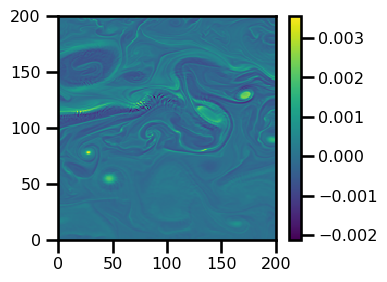

In [84]:
fig, ax = plt.subplots(figsize=(4,3))

pts = ax.pcolormesh(q)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [85]:
def ssh_2_ssh0(ssh):
    ssh = ssh.at[1:-1,1:-1].set(0.0)
    return ssh

In [86]:
ssh_0 = ssh_2_ssh0(jnp.asarray(ssh))

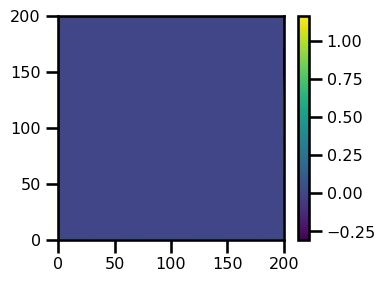

In [87]:
fig, ax = plt.subplots(figsize=(4,3))

pts = ax.pcolormesh(ssh_0)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [88]:
q0 = ssh_to_pv(ssh_0, g=g, f0=f0, c1=c1)
q0 = bc_q_fn(q0, ssh_0)

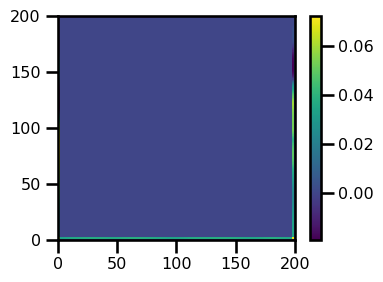

In [89]:
fig, ax = plt.subplots(figsize=(4,3))

pts = ax.pcolormesh(q0)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

**Step IV**: We compute the boundary effects of $q_0$ from the potential vorticity $q$

$$
\begin{aligned}
q_\xi &= q - q_0 && && \vec{\mathbf{x}}\in\Omega 
\end{aligned}
$$

In [90]:
q_xi = q[1:-1,1:-1] - q0[1:-1,1:-1]

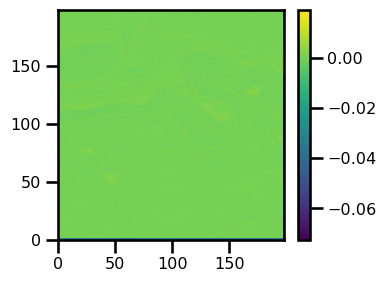

In [91]:
fig, ax = plt.subplots(figsize=(4,3))

pts = ax.pcolormesh(q_xi)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [92]:
def dstI1D(x, norm='ortho'):
    """1D type-I discrete sine transform."""
    return jnp.fft.irfft(-1j*jnp.pad(x, (1,1)), axis=-1, norm=norm)[1:x.shape[0]+1,1:x.shape[1]+1]


def dstI2D(x, norm='ortho'):
    """2D type-I discrete sine transform."""
    return dstI1D(dstI1D(x, norm=norm).T, norm=norm).T



def inverse_elliptic_dst(f, operator_dst):
    """Inverse elliptic operator (e.g. Laplace, Helmoltz)
    using float32 discrete sine transform."""
    return dstI2D(dstI2D(f) / operator_dst)


In [93]:
x, y = np.meshgrid(np.arange(1,nx-1,dtype='float64'),
                   np.arange(1,ny-1,dtype='float64'))
laplace_dst = 2*(np.cos(np.pi/(nx-1)*x) - 1)/np.mean(dx)**2 + \
    2*(np.cos(np.pi/(ny-1)*y) - 1)/np.mean(dy)**2

In [94]:
# helmoltz_dst = (g/f0) * laplace_dst  - (g*f0)/c1**2
helmoltz_dst = (g/f0) * laplace_dst  #- (g*f0)/c1**2

In [95]:
assert helmoltz_dst.shape == q_xi.shape

In [96]:
eta_xi = inverse_elliptic_dst(q_xi, helmoltz_dst)

In [97]:
ssh_rec = jnp.asarray(ssh.copy())
ssh_rec = ssh_rec.at[1:-1,1:-1].set(eta_xi)

In [98]:
print(np.max(np.abs(ssh_rec - ssh)))

1.5909495942878493e-13


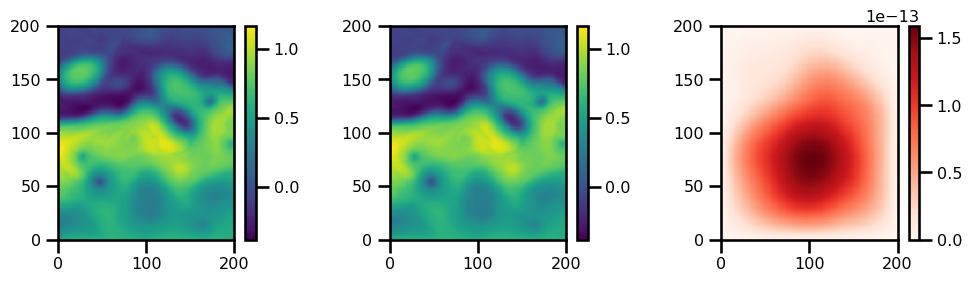

In [99]:
vmin = min_arrays(ssh_rec, ssh)
vmax = max_arrays(ssh_rec, ssh)

fig, ax = plt.subplots(ncols=3, figsize=(10,3))
pts = ax[0].pcolormesh(ssh, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[1].pcolormesh(ssh_rec, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[2].pcolormesh(np.abs(ssh-ssh_rec), cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Potential Vorticity

#### Reference

Here, we need to transform the SSH, $\eta$, to the stream function, $\psi$, and the potential vorticity, $q$. So using all of the equations list above, we calculate the potential vorticity like so:

$$
\begin{aligned}
\psi_0 &= \frac{g}{f_0}\eta_0 \\
q_{0} &= \frac{g}{f_0}\nabla^2 \psi_0 - \frac{gf_0^2}{c_1^2}\psi_0
\end{aligned}
$$

MY VERSION:

$$
\begin{aligned}
\psi_0 &= \frac{g}{f_0}\eta_0 \\
q_{0} &= \nabla^2 \psi_0 - \frac{1}{c_1^2}\psi_0
\end{aligned}
$$

Then we need to add the boundary condition. For this one, we will add the same boundary

$$
\begin{aligned}
\boldsymbol{b}(q_{0},\psi_0;\boldsymbol{\theta}) &= \frac{}{} \\
q_{b} &= \boldsymbol{b}(q_{0},\psi_0;\boldsymbol{\theta})
\end{aligned}
$$

In [92]:
import finitediffx as fdx

def _laplace(h):

        return (h[2:,1:-1]+h[:-2,1:-1]-2*h[1:-1,1:-1])/dy**2 + (h[1:-1,2:]+h[1:-1,:-2]-2*h[1:-1,1:-1])/dx**2
    
def bcs_f(pv):
    
    # Boundary condition
    pv_ref[0,:] = -g*f0/(c1**2) * ssh[0,:]
    pv_ref[-1,:] = -g*f0/(c1**2) * ssh[-1,:]
    pv_ref[:,0] = -g*f0/(c1**2) * ssh[:,0]
    pv_ref[:,-1] = -g*f0/(c1**2) * ssh[:,-1]
    

In [126]:
pv_ref = np.zeros_like(ssh)
ssh_lap = _laplace(ssh)
pv_ref[1:-1,1:-1] = g/f0 * (ssh_lap - (f0/c1)**2 * ssh[1:-1,1:-1])


In [127]:
# ========================
# POTENTIAL VORTICITY 
# ========================

# REFERENCE (w/ BOUNDARIES)
ssh_lap = fdx.laplacian(ssh, accuracy=1, step_size=(dx, dy))

pv_ref_ = g/f0 * (ssh_lap- (f0/c1)**2 * ssh)

In [128]:
# np.testing.assert_array_almost_equal(pv_ref_[1:-1,1:-1], pv_ref[1:-1,1:-1])

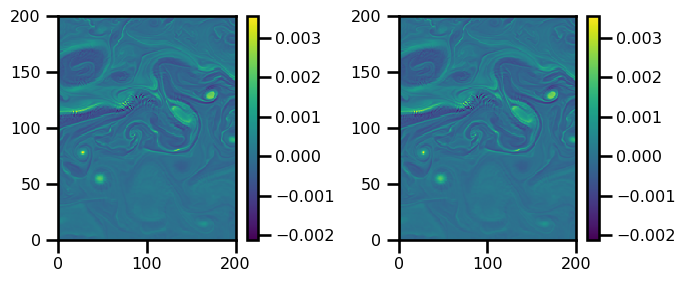

In [129]:
vmin = min_arrays(pv_ref, pv_ref_)
vmax = max_arrays(pv_ref, pv_ref_)

fig, ax = plt.subplots(ncols=2, figsize=(7,3))

pts = ax[0].pcolormesh(pv_ref, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts =ax[1].pcolormesh(pv_ref_, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [130]:
# Boundary condition
pv_ref[0,:] = -g*f0/(c1**2) * ssh[0,:]
pv_ref[-1,:] = -g*f0/(c1**2) * ssh[-1,:]
pv_ref[:,0] = -g*f0/(c1**2) * ssh[:,0]
pv_ref[:,-1] = -g*f0/(c1**2) * ssh[:,-1]


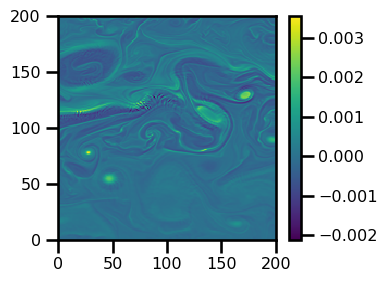

In [131]:
fig, ax = plt.subplots(figsize=(4,3))
pts = ax.pcolormesh(pv_ref)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

#### Boundary Contribution

Here, we use the exact same equation as before. But this time, we will set all interior points of the SSH to zero and then we proceed.

$$
\begin{aligned}
\psi_0 &= \frac{g}{f_0}\eta_0 \\ 
q_{0} &= \nabla^2 \psi_0- \frac{1}{c_1^2}\psi_0 \\ 
q_{b} &= \boldsymbol{b}(q_{0},\psi_0;\boldsymbol{\theta})
\end{aligned} 
$$

By doing this, we are solving the equation and calculating the effect of the boundary on our problem.

In [132]:
# ========================
# POTENTIAL VORTICITY (BC Contribution)
# ========================
ssh_bv = np.copy(ssh)
ssh_bv[1:-1,1:-1] = 0
pv_bv = np.zeros_like(ssh)

pv_bv[1:-1,1:-1] = g/f0 * (_laplace(ssh_bv) - (f0/c1)**2 * ssh_bv[1:-1,1:-1])

# Boundary condition
pv_bv[0,:] = -g*f0/(c1**2) * ssh_bv[0,:]
pv_bv[-1,:] = -g*f0/(c1**2) * ssh_bv[-1,:]
pv_bv[:,0] = -g*f0/(c1**2) * ssh_bv[:,0]
pv_bv[:,-1] = -g*f0/(c1**2) * ssh_bv[:,-1]

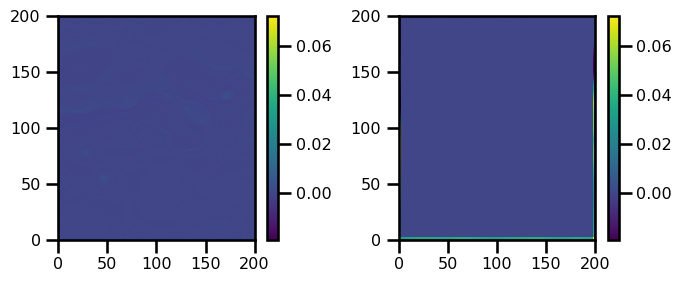

In [133]:
vmin = min_arrays(pv_ref, pv_bv)
vmax = max_arrays(pv_ref, pv_bv)

fig, ax = plt.subplots(ncols=2, figsize=(7,3))

pts = ax[0].pcolormesh(pv_ref, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts =ax[1].pcolormesh(pv_bv, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

#### Potential Vorticity (Interior)

In [134]:
# =======================================
# POTENTIAL VORTICITY (Interior Points)
# ======================================
# remove the boundary effect on PV
pv_in = pv_ref[1:-1,1:-1] - pv_bv[1:-1,1:-1]

In [135]:
pv_in.shape, pv_ref.shape, pv_bv.shape

((198, 198), (200, 200), (200, 200))

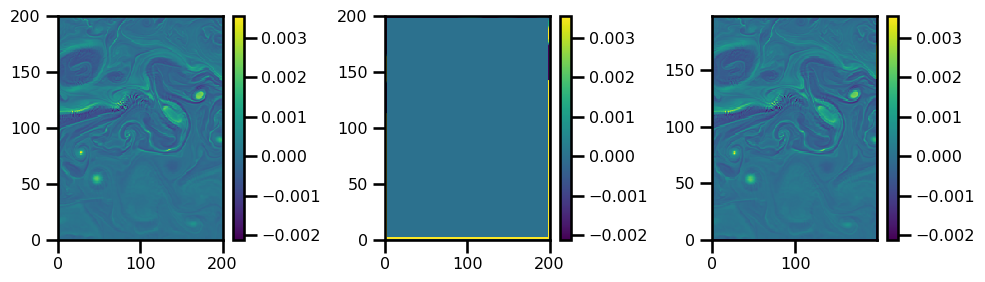

In [136]:
vmin = min_arrays(pv_ref, pv_bv, pv_in)
vmax = max_arrays(pv_ref, pv_bv, pv_in)

fig, ax = plt.subplots(ncols=3, figsize=(10,3))

pts = ax[0].pcolormesh(pv_ref, vmin=pv_ref.min(), vmax=pv_ref.max(), )
plt.colorbar(pts)
pts = ax[1].pcolormesh(pv_bv, vmin=pv_ref.min(), vmax=pv_ref.max())
plt.colorbar(pts)
pts = ax[2].pcolormesh(pv_in, vmin=pv_ref.min(), vmax=pv_ref.max())
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Inverse Potential Vorticity

We are basically solving a PDE of the form

$$
\begin{aligned}
u &= \boldsymbol{u}(\mathbf{x}) \\
\text{s.t. } \nabla^2 u 
\end{aligned}
$$ (eq:lap_pde)

We can recognize this as the Poisson equation

$$

$$

### Helmholtz Equation

$$
\begin{aligned}
\nabla^2 f +  k^2 f &= 0 \\
(\nabla^2 + k^2) f &= 0
\end{aligned}
$$


Sources:
* [Wikipedia](https://en.wikipedia.org/wiki/Helmholtz_equation)

In [137]:
def compute_laplace_dst(nx, ny, dx, dy, dtype):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = np.meshgrid(np.arange(1,nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')
    return 2*(np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + 2*(np.cos(np.pi/(ny-1)*y) - 1)/dy**2

In [138]:
# Compute helmottz operator
laplace_dst = compute_laplace_dst(nx, ny, dx, dy, dtype)
helmoltz_dst = g/f0 * laplace_dst  - g*f0/c1**2

In [139]:
laplace_dst.min(), laplace_dst.max(), helmoltz_dst.min(), helmoltz_dst.max()

(-4.999688473794144e-07,
 -3.11526205856727e-11,
 -0.49548272171733426,
 -4.446621133510672e-05)

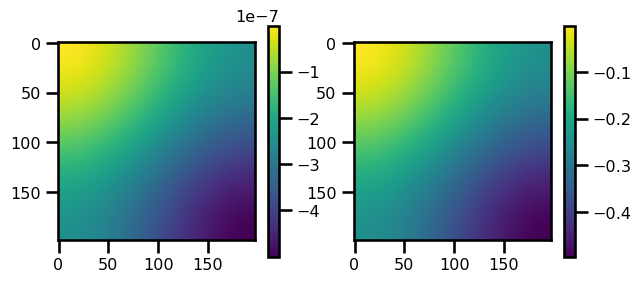

In [140]:
fig, ax = plt.subplots(ncols=2, figsize=(7,3))

pts = ax[0].imshow(laplace_dst)
plt.colorbar(pts)
pts = ax[1].imshow(helmoltz_dst)
plt.colorbar(pts)
plt.show()

### Discrete Sine Transform

Here we use the discrete sine transform (DCT)

In [141]:
import scipy
# Get pv from sine transform
pv_in_hat = scipy.fftpack.dst(scipy.fftpack.dst(pv_in,norm=norm, type=1).T, norm=norm, type=1).T

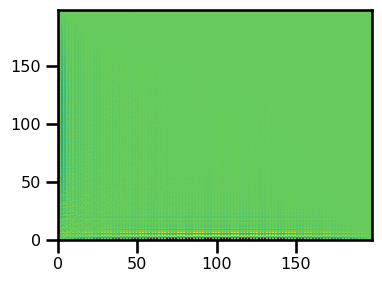

In [142]:
fig, ax = plt.subplots(figsize=(4,3))

ax.pcolormesh(pv_in_hat)

plt.tight_layout()
plt.show()

### Inverse Sine Transform

Here we use the inverse DCT (IDCT)


$$
\begin{aligned}
\text{Real}: && && \psi &= \mathbf{L}^{-1}q \\
\text{Fourier}: && && \hat{\psi} &= \frac{1}{\hat{\mathbf{L}}}\hat{q}
\end{aligned}
$$

where $\mathbf{L}=\left(\nabla^2 - \frac{1}{L_R^2}\right)$

In [143]:
# Inverse sine tranfrom to get reconstructed ssh
ssh_rec = np.zeros_like(ssh)
ssh_rec[1:-1,1:-1] = scipy.fftpack.idst(
        scipy.fftpack.idst(pv_in_hat/helmoltz_dst, norm=norm, type=1).T,
    norm=norm, type=1).T

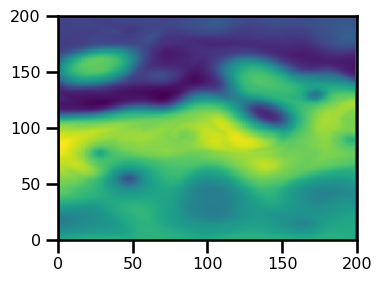

In [144]:
fig, ax = plt.subplots(figsize=(4,3))

ax.pcolormesh(ssh_rec)

plt.tight_layout()
plt.show()

## PV Boundary

In [145]:
# add the boundary value on SSH
ssh_rec_true = ssh_rec + ssh_bv

In [146]:
print(
    np.max(np.abs(ssh - ssh_bv)), 
    np.max(np.abs(ssh - ssh_rec)), 
    np.max(np.abs(ssh - ssh_rec_true))
)

1.159965991973877 1.1638191938400269 1.2090328738167955e-13


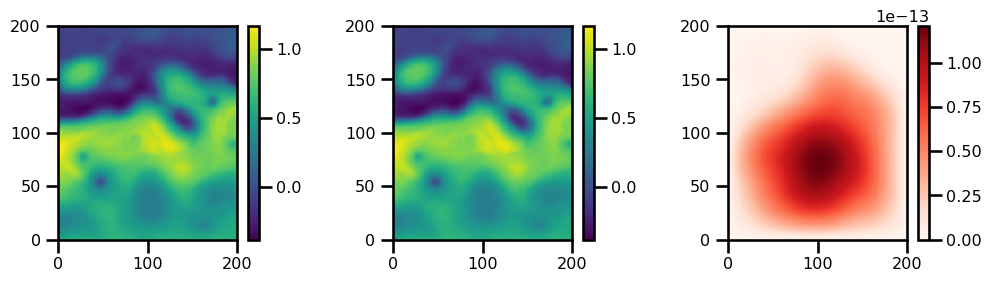

In [41]:
vmin = min_arrays(ssh, ssh_rec)
vmax = max_arrays(ssh, ssh_rec)

fig, ax = plt.subplots(ncols=3, figsize=(10,3))
pts = ax[0].pcolormesh(ssh, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[1].pcolormesh(ssh_rec, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[2].pcolormesh(np.abs(ssh-ssh_rec), cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

$$
\begin{aligned}
\psi &= \frac{g}{f_0} \eta \\
q &= \nabla^2\psi - \frac{1}{L_R^2}\psi \\
q &= \frac{g}{f_0}\nabla^2\eta - \frac{gf_0^2}{c_1^2}\eta
\end{aligned}
$$

### Laplacian Term

$$
\text{Lap}[\mathbf{u}](\mathbf{x}):= \nabla^2\eta
$$

In [42]:
norm = 'ortho'

dtype = 'float64' # 'float64'
ssh = ssh.astype(dtype)

ssh_lap = fdx.laplacian(ssh, accuracy=2, step_size=(dx, dy))
assert ssh.shape == ssh_lap.shape

ssh_lap_ = _laplace(ssh)
assert ssh[1:-1,1:-1].shape == ssh_lap_.shape

In [43]:
import functools as ft

min_ = np.min(np.stack([ssh_lap.min(), ssh_lap_.min()],axis=0))
max_ = np.max(np.stack([ssh_lap.max(), ssh_lap_.max()],axis=0))

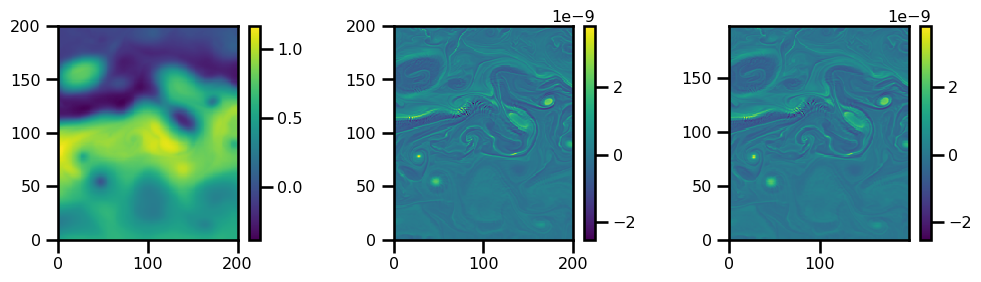

In [44]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))


pts = ax[0].pcolormesh(ssh)
plt.colorbar(pts)
pts = ax[1].pcolormesh(ssh_lap, vmin=min_, vmax=max_)
plt.colorbar(pts)
pts = ax[2].pcolormesh(ssh_lap_, vmin=min_, vmax=max_)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### SSH to Potential Vorticity

$$
\begin{aligned}
\psi &= \frac{g}{f_0} \eta \\
q &= \nabla^2\psi - \frac{1}{L_R^2}\psi \\
q &= \frac{g}{f_0}\nabla^2\eta - \frac{gf_0^2}{c_1^2}\eta
\end{aligned}
$$

In [46]:
class SSH2PV(eqx.Module):
    g: float = eqx.static_field()
    f0: float = eqx.static_field()
    c1: float = eqx.static_field()
    dx: Array = eqx.static_field()
    dy: Array = eqx.static_field()
    accuracy: int = eqx.static_field()
    
    def __call__(self, ssh):
        
        ssh_lap = fdx.laplacian(ssh, accuracy=self.accuracy, step_size=(self.dx, self.dy))
        
        pv = (self.g/self.f0) * (ssh_lap - (self.f0/self.c1)**2 * ssh)
        
        return pv

In [53]:
pv_ = np.zeros_like(ssh)

pv_[1:-1,1:-1] = g/f0 * (_laplace(ssh) - (f0/c1)**2 * ssh[1:-1,1:-1])

In [54]:
ssh2pv_f = SSH2PV(g=g,f0=f0,c1=c1,dx=dx,dy=dy,accuracy=2)

pv = ssh2pv_f(ssh)
assert pv.shape == ssh.shape

In [56]:
import functools as ft

vmin = np.min(np.stack([pv.min(), pv_.min()],axis=0))
vmax = np.max(np.stack([pv.max(), pv_.max()],axis=0))

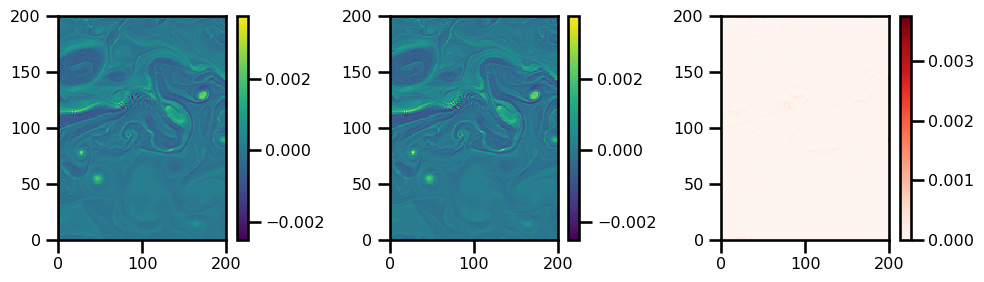

In [62]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))

pts = ax[0].pcolormesh(pv_, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[1].pcolormesh(pv, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[2].pcolormesh(np.abs(pv-pv_), vmin=0.0, vmax=vmax, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [ ]:
def ssh_to_pv(ssh, dx, dy, g, f):
    
    ssh_lap = fdx.laplacian(ssh, accuracy=2, step_size=(dx, dy))
    
    
    
    return pv

### Boundaries: Potential Vorticity

In [68]:
class SSH2PV(eqx.Module):
    g: float = eqx.static_field()
    f0: float = eqx.static_field()
    c1: float = eqx.static_field()
    dx: Array = eqx.static_field()
    dy: Array = eqx.static_field()
    accuracy: int = eqx.static_field()
    
    def __call__(self, ssh):
        
        ssh_lap = fdx.laplacian(ssh, accuracy=self.accuracy, step_size=(self.dx, self.dy))
        
        pv = (self.g/self.f0) * (ssh_lap - (self.f0/self.c1)**2 * ssh)
        
        return pv

class InteriorZero(eqx.Module):
    
    def __call__(self, x):
        
        x = x.at[1:-1, 1:-1].set(0.0)
        
        return x
    
class BCPV(eqx.Module):
    g: float = eqx.static_field()
    f0: float = eqx.static_field()
    c1: float = eqx.static_field()
    
    def __call__(self, pv, bc):
        
        pv = pv.at[0,:].set(-self.g*self.f0/(self.c1**2) * bc[0,:])
        pv = pv.at[-1,:].set(-self.g*self.f0/(self.c1**2) * bc[-1,:])
        pv = pv.at[:,0].set(-self.g*self.f0/(self.c1**2) * bc[:,0])
        pv = pv.at[:,-1].set(-self.g*self.f0/(self.c1**2) * bc[:,-1])
        
        return pv
        

In [79]:
# ssh boundary value
ssh_bv = np.copy(ssh)
ssh_bv[1:-1,1:-1] = 0

pv_ref_ = np.zeros_like(ssh)

pv_ref_[1:-1,1:-1] = g/f0 * (_laplace(ssh) - (f0/c1)**2 * ssh[1:-1,1:-1])

# Boundary condition
pv_ref_[0,:] = -g*f0/(c1**2) * ssh_bv[0,:]
pv_ref_[-1,:] = -g*f0/(c1**2) * ssh_bv[-1,:]
pv_ref_[:,0] = -g*f0/(c1**2) * ssh_bv[:,0]
pv_ref_[:,-1] = -g*f0/(c1**2) * ssh_bv[:,-1]

In [95]:
ssh2pv_f = SSH2PV(g=g,f0=f0,c1=c1,dx=dx,dy=dy,accuracy=1)
int0_f = InteriorZero()
bcpv_f = BCPV(g=g, f0=f0, c1=c1)

pv_ref = ssh2pv_f(ssh)
pv_ref = bcpv_f(pv_ref, ssh)

ssh_j = jnp.asarray(ssh)
ssh_bv = int0_f(ssh_j)
pv_bc = ssh2pv_f(ssh_bv)
pv_bc = bcpv_f(pv_bc, ssh_bv)
assert pv_ref.shape == ssh.shape == pv_bc.shape == ssh_j.shape

In [96]:
import functools as ft

vmin = np.min(np.stack([pv_ref.min(), pv_ref_.min()],axis=0))
vmax = np.max(np.stack([pv_ref.max(), pv_ref_.max()],axis=0))

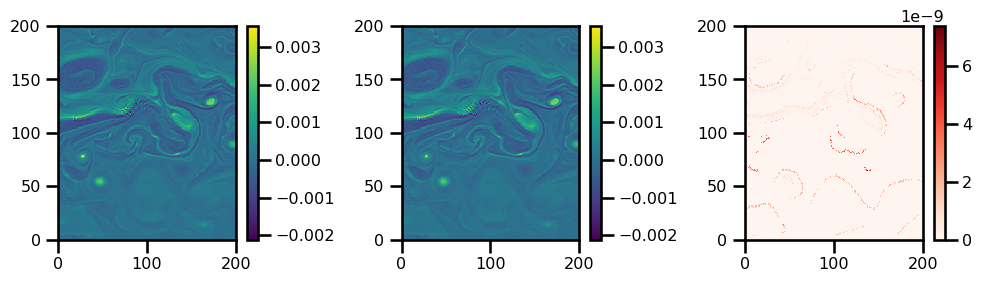

In [97]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))

pts = ax[0].pcolormesh(pv_ref_, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[1].pcolormesh(pv_ref, vmin=vmin, vmax=vmax)
plt.colorbar(pts)
pts = ax[2].pcolormesh(np.abs(pv_ref-pv_ref_), vmin=0.0, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [6]:

def ssh2pv(h, ssh_bv):
    
        q = np.zeros_like(h)
        
        q[1:-1,1:-1] = g/f0 * (_laplace(h) - (f0/c1)**2 * h[1:-1,1:-1])
        
        # Boundary condition
        q[0,:] = -g*f0/(c1**2) * ssh_bv[0,:]
        q[-1,:] = -g*f0/(c1**2) * ssh_bv[-1,:]
        q[:,0] = -g*f0/(c1**2) * ssh_bv[:,0]
        q[:,-1] = -g*f0/(c1**2) * ssh_bv[:,-1]
    
        return q



def compute_laplace_dst(nx, ny, dx, dy, dtype):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = np.meshgrid(np.arange(1,nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')
    return 2*(np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + 2*(np.cos(np.pi/(ny-1)*y) - 1)/dy**2


## Inverse elliptical equation


This is bad:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{\psi} \\
\mathbf{q} &= \mathbf{f} 
\end{aligned}
$$

This is also bad:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{\psi} \\
\mathbf{q} &= \mathbf{0} 
\end{aligned}
$$

This is good:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{0} \\
\mathbf{q} &= \mathbf{f} 
\end{aligned}
$$

Technique de relevement.

**Sources**:
* [Blog Post](https://bthierry.pages.math.cnrs.fr/course-fem/lecture/boundary-conditions/dirichlet/)

## New API

In [ ]:
from jaxsw._src.domain import Domain
import finitediffx as fdx
from jaxsw._src.fields.base import Field

In [ ]:
# create domain
Nx = lon.size - 1
Ny = lat.size - 1
dx, dy = 4_000, 4_000

domain = Domain(xmin=(0,0), xmax=(dx * Nx, dy * Ny), dx=(dx, dy))
domain.size, domain.dx

((200, 200), (4000, 4000))

In [ ]:
# create field
u_eta = Field(ssh.astype("float64"), domain)

u_eta.values.shape, u_eta.domain.size

((200, 200), (200, 200))